### Load Package

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa.display import *
from librosa.effects import *

import os

### Preprocessing

In [148]:
os.chdir("/Users/hyunwoogu/Dropbox/2018MARG/Emotion Recognition/Dataset/RAVDESS")

In [140]:
Happy = "03-01-03-{0[0]:02d}-{0[1]:02d}-{0[2]:02d}-{0[3]:02d}.wav"
Sad   = "03-01-04-{0[0]:02d}-{0[1]:02d}-{0[2]:02d}-{0[3]:02d}.wav"

Happy_train = np.zeros([128, 44])
Sad_train   = np.zeros([128, 44])

k = [(1, 1, 1), (1, 1, 2), (1, 2, 1), (1, 2, 2), (2, 1, 1), (2, 1, 2), (2, 2, 1), (2, 2, 2)]

In [151]:
def add_noise(wav):
    wn = np.random.normal(len(wav))
    wav_noise = wav + 0.05*wn
    return (wav_noise)

In [126]:
data, fs = librosa.load("CB_Happy.wav")

n    = data.size
        
threshold   = np.ptp(data/100)

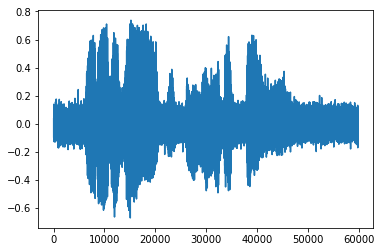

In [139]:
plt.plot(range(len(add_noise(data))), add_noise(data))

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


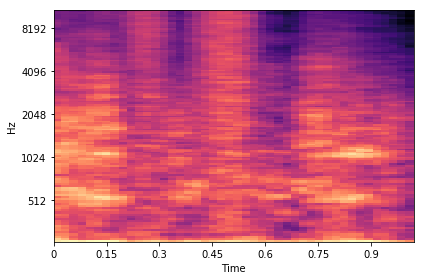

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111)
        
fig.show()
fig.canvas.draw()

for i in k:
    for j in range(1, 25):
        index = (i, j)
        index = index[0] + (index[1],)
        
        files    = Sad.format(index)
        data, fs = librosa.load(files)

        n    = data.size
        
        threshold   = np.ptp(data/100)
        EffectiveInx= np.argwhere(data > threshold)
        Effective   = data[EffectiveInx]
        n           = Effective.size
        Effective   = np.reshape(Effective, [n])
        
        Effective_stretch = librosa.effects.time_stretch(Effective, n / fs)
        S = librosa.feature.melspectrogram(Effective_stretch, sr=fs, n_mels=128)
        log_S = librosa.logamplitude(S, ref_power=np.max)
        log_S = log_S[:, range(44)]
        
        ax.clear()
        specshow(log_S, sr=fs, x_axis='time', y_axis='mel')
        fig.canvas.draw()
        plt.tight_layout()
                
        Sad_train = np.vstack((Sad_train, log_S))

In [150]:
os.chdir("/Users/hyunwoogu/Dropbox/2018MARG/Emotion Recognition/Emotional Speech Recognition/pitch_detection")

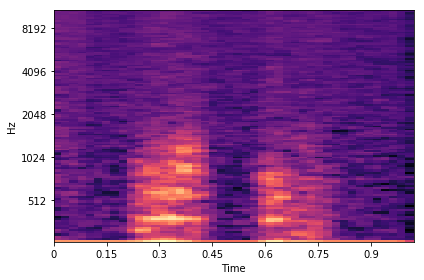

In [152]:
for i in range(12):
    data, fs = librosa.load("TH_Sad.wav")
    n        = data.size
    data     = add_noise(data)

    threshold   = np.ptp(data/100)
    EffectiveInx= np.argwhere(data > threshold)
    Effective   = data[EffectiveInx]
    n           = Effective.size
    Effective   = np.reshape(Effective, [n])
        
    Effective_stretch = librosa.effects.time_stretch(Effective, n / fs)
    S = librosa.feature.melspectrogram(Effective_stretch, sr=fs, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    log_S = log_S[:, range(44)]
        
    ax.clear()
    specshow(log_S, sr=fs, x_axis='time', y_axis='mel')
    fig.canvas.draw()
    plt.tight_layout()
    
    Sad_train = np.vstack((Sad_train, log_S))        
        
Sad_train = np.reshape(Sad_train, [24*8+12+1, 128, 44])
Sad_train = Sad_train[1:, :, :]

In [154]:
xTrain = np.vstack((Happy_train, Sad_train))
xTrain = np.reshape(xTrain, [408, 128, 44])
yTrain = np.repeat(np.array([1, 0]), 204)

In [155]:
inx = np.array(range(408))
np.random.shuffle(inx)
trainInx=inx[0:300]
testInx =inx[300:408]

In [156]:
x_train = xTrain[trainInx, :, :]
y_train = yTrain[trainInx]

x_test  = xTrain[testInx, :, :]
y_test = yTrain[testInx]

### Model

In [157]:
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import adam
from scipy.misc import toimage #(*)
import matplotlib.pylab as plt
%matplotlib inline

In [158]:
batch_size = 4
epoch = 20
num_classes = 2

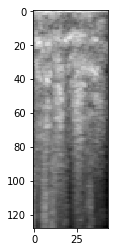

In [166]:
im = x_test[107]
plt.imshow(im, cmap=plt.get_cmap('gray'))
plt.show()

In [167]:
x_train_RS = x_train.reshape(300, 128, 44, 1)
x_test_RS  = x_test.reshape(108, 128, 44, 1)

x_train_RS = x_train_RS.astype('float32')
x_test_RS  = x_test_RS.astype('float32')

x_train_RS /= 80
x_test_RS  /= 80

y_train_RS = to_categorical(y_train, num_classes)
y_test_RS  = to_categorical(y_test, num_classes)

In [168]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(128, 44, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 125, 41, 32)       544       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 17, 64)        32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 8, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1900672   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total para

### Train

In [169]:
model.fit(x_train_RS, y_train_RS, 
          batch_size=batch_size, epochs=epoch, verbose=1, 
          validation_data=(x_test_RS, y_test_RS))
loss, accuracy = model.evaluate(x_test_RS, y_test_RS, verbose=0)

Train on 300 samples, validate on 108 samples
Epoch 1/20
300/300 [==============================] - 4s 13ms/step - loss: 0.7314 - acc: 0.4800 - val_loss: 0.6931 - val_acc: 0.5185
Epoch 2/20
300/300 [==============================] - 3s 11ms/step - loss: 0.6936 - acc: 0.4800 - val_loss: 0.6933 - val_acc: 0.4815
Epoch 3/20
300/300 [==============================] - 3s 12ms/step - loss: 0.6934 - acc: 0.4867 - val_loss: 0.6931 - val_acc: 0.4815
Epoch 4/20
300/300 [==============================] - 3s 12ms/step - loss: 0.6981 - acc: 0.4933 - val_loss: 0.6934 - val_acc: 0.4815
Epoch 5/20
300/300 [==============================] - 3s 12ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4815
Epoch 6/20
300/300 [==============================] - 3s 12ms/step - loss: 0.6945 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.4815
Epoch 7/20
300/300 [==============================] - 4s 12ms/step - loss: 0.6937 - acc: 0.5133 - val_loss: 0.6907 - val_acc: 0.5648
Epoch 8/20
300/300 [===

In [170]:
accuracy

0.64814814594056869

In [171]:
model.save_weights("weight_180208.hdf5")

### predict

In [172]:
def EmotionPredictor(files):
    fig = plt.figure()
    ax = fig.add_subplot(111)
        
    fig.show()
    fig.canvas.draw()
    
    
    data, fs = librosa.load(files)

    n    = data.size

    EffectiveInx= np.argwhere(data > threshold)
    Effective   = data[EffectiveInx]
    n           = Effective.size
    Effective   = np.reshape(Effective, [n])
        
    Effective_stretch = librosa.effects.time_stretch(Effective, n / fs)
    S = librosa.feature.melspectrogram(Effective_stretch, sr=fs, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    log_S = log_S[:, range(44)]
        
    ax.clear()
    specshow(log_S, sr=fs, x_axis='time', y_axis='mel')
    fig.canvas.draw()
    plt.tight_layout()
                
    log_S = np.reshape(log_S, [1, 128, 44, 1])

    log_S = log_S.astype('float32')
    log_S /= 80

    predict = model.predict(log_S)
    if (np.argmax(predict, axis=1)==[1]):
        print("You Are Happy!")
    elif (np.argmax(predict, axis=1)==[0]):
        print("You Are Sad..")

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


You Are Happy!


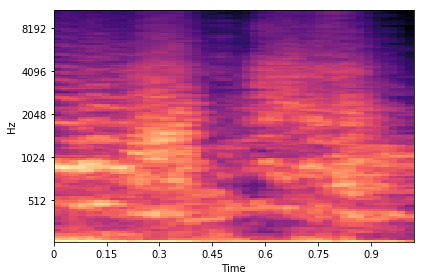

In [178]:
EmotionPredictor("CB_Happy.wav")

JR_Happy
HW_Sad
CB_Happy
CH_Sad
=> Correct

HW_Happy
=> False